#Importing packages

In [ ]:
import numpy as np
from numpy import expand_dims
import pandas as pd
import os
import cv2
import csv
import copy
import shutil
import math
import random
import PIL

from collections import Counter
from PIL import Image
from random import sample, choices
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.image as mpimg
# %matplotlib inline  # Uncomment this if you are using Jupyter notebook
matplotlib.style.use("ggplot")

import tensorflow as tf
from tensorflow import keras

import tensorflow.keras.preprocessing.image
from tensorflow.keras import regularizers
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Lambda, Reshape, Dense, Dropout, Flatten, BatchNormalization, Activation, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.constraints import MaxNorm
# from tensorflow.keras.utils import np_utils  # Removed this line as np_utils is not available in tensorflow.keras.utils
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Input, optimizers, layers, models, callbacks, applications
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

from skimage.transform import resize
from IPython.display import SVG

Since the dataset is too big to add to Google Colab runfiles, it must be imported from Google Drive. First, we mount the drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Preprocessing

##Splitting the Data into Train/Test

Before proceeding with any preprocessing steps, it's crucial to partition the data into training and test/validation sets. This step is necessary to prevent data leakage into the validation data.

The code below accomplishes this by generating a new directory in Google Drive and organizing the images into separate training and test folders based on the train_test_split text file provided by the website. Once this is done, we can access these folders and convert the images into arrays to prepare them for preprocessing.

In [ ]:
#Name the root directory so the code knows where to go
root_dir = '/content/drive/MyDrive/CUB_200_2011 (1)/CUB_200_2011'

#Name the original images folder
orig_images_folder = '/content/drive/MyDrive/CUB_200_2011 (1)/CUB_200_2011/images'

#Create a new folder for sorted images
new_images_folder = '/content/drive/MyDrive/CUB_200_2011 (1)/CUB_200_2011/images_sorted'

In [ ]:
#Join the path to the overall folder and original images folder
data_dir = os.path.join(root_dir, orig_images_folder)

#Do the same for the sorted images folder
new_data_dir = os.path.join(root_dir, new_images_folder)

In [ ]:
#Load the image file paths into a pandas dataframe for later use
image_fnames = pd.read_csv(filepath_or_buffer=os.path.join(root_dir,'/content/drive/MyDrive/CUB_200_2011 (1)/CUB_200_2011/images.txt'),
                          header=None,
                          delimiter=' ',
                          names=['Img ID', 'file path'])

#Do the same for the train_test_split text file
image_fnames['is training image?'] = pd.read_csv(filepath_or_buffer=os.path.join(root_dir,'/content/drive/MyDrive/CUB_200_2011 (1)/CUB_200_2011/train_test_split.txt'),
                                                 header=None, delimiter=' ',
                                                 names=['Img ID','is training image?'])['is training image?']

In [ ]:
#Create folders inside the sorted images folder for training and test data
os.makedirs(os.path.join(new_data_dir,'train'), exist_ok=True)
os.makedirs(os.path.join(new_data_dir,'test'), exist_ok=True)

In [ ]:
# Loop over each image file name in the dataframe
for i_image, image_fname in enumerate(image_fnames['file path']):
    # Check if the current image is a training image
    if image_fnames['is training image?'].iloc[i_image]:
        # If it is a training image, create a new directory path under the 'train' directory
        new_dir = os.path.join(new_data_dir,'train',image_fname.split('/')[0])
        # Create the new directory if it doesn't exist
        os.makedirs(new_dir, exist_ok=True)
        # Copy the image file to the new directory
        shutil.copy(src=os.path.join(data_dir,image_fname), dst=os.path.join(new_dir, image_fname.split('/')[1]))
    else:
        # If it is not a training image, it is assumed to be a test image
        # Create a new directory path under the 'test' directory
        new_dir = os.path.join(new_data_dir,'test',image_fname.split('/')[0])
        # Create the new directory if it doesn't exist
        os.makedirs(new_dir, exist_ok=True)
        # Copy the image file to the new directory
        shutil.copy(src=os.path.join(data_dir,image_fname), dst=os.path.join(new_dir, image_fname.split('/')[1]))


##Testing Techniques on a Small Sample

With the creation of new folders containing the train and test data, we can proceed to preprocess the training images.

However, before diving into preprocessing, it's beneficial to examine the impact of various preprocessing techniques on a small subset of the training data. This enables us to efficiently assess the necessary adjustments required for the images before constructing a preprocessing pipeline.








In [ ]:
# Define a function to split the dataset into training and validation sets
def split_trainval_CUB200(path_root_CUB200, n_sample=0):

    # Define the paths to the directories where the images are stored
    path_data_all = os.path.join(path_root_CUB200, "images")
    path_data_train = os.path.join('/content/drive/MyDrive/CUB_200_2011 (1)/CUB_200_2011/images_sorted/train')
    path_data_valid = os.path.join('/content/drive/MyDrive/CUB_200_2011 (1)/CUB_200_2011/images_sorted/test')

    # Create the directories for the training and validation sets if they don't exist
    os.makedirs(path_data_train, exist_ok=True)
    os.makedirs(path_data_valid, exist_ok=True)

    # Iterate over each subdirectory in the directory containing all images
    for subdir, dirs, files in os.walk(path_data_all):

        # Get the name of the current subdirectory
        name_class = os.path.basename(subdir)

        # Skip the root directory
        if name_class == os.path.basename(path_data_all):
            continue

        # Define the paths to the directories for the current class in the training and validation sets
        path_dir_train = os.path.join(path_data_train, name_class)
        path_dir_valid = os.path.join(path_data_valid, name_class)

        # Create the directories for the current class in the training and validation sets if they don't exist
        os.makedirs(path_dir_train, exist_ok=True)
        os.makedirs(path_dir_valid, exist_ok=True)

    # Load the lists of image paths, labels, and training/test flags from the text files
    list_path_file = np.genfromtxt(os.path.join(path_root_CUB200, 'images.txt'), dtype=str)
    list_label_file = np.genfromtxt(os.path.join(path_root_CUB200, 'image_class_labels.txt'), dtype=np.uint8)
    list_flg_split = np.genfromtxt(os.path.join(path_root_CUB200, 'train_test_split.txt'), dtype=np.uint8)

    # Set the maximum number of files for the loop to process
    max_file = len(list_path_file)

    # Initialize lists to store the mean and standard deviation of the training data
    list_mean_train = np.zeros(3)
    list_std_train =  np.zeros(3)

    # Initialize a list to store a sample of images for testing
    list_sample = []

    # Initialize counters for the number of training and validation images
    count_train = 0
    count_valid = 0

    # Loop over each file in the list of image files
    for i in range(len(list_path_file)):

      # Construct the path to the current image file
      path_file = os.path.join(path_data_all, list_path_file[i, 1])

      # Open the current image file
      image = PIL.Image.open(path_file)

      # If the image is grayscale, convert it to RGB
      if image.getbands()[0] == 'L':
          image = image.convert('RGB')
      image_np = np.array(image)
      image.close()

      # If the sample list is not yet full, add the current image to it
      if count_train + count_valid < n_sample:
          list_sample.append(image_np)

      # If the current image is a training image, add it to the training data
      if list_flg_split[i, 1] == 1:
          # Increment the counter for training images
          count_train += 1
          path_file_copy = os.path.join(path_data_train, list_path_file[i, 1])
          if not os.path.exists(path_file_copy):
              shutil.copy(path_file, path_file_copy)
          # Update the mean and standard deviation for the training images
          for dim in range(3):
              list_mean_train[dim] += image_np[:,:,dim].mean()
              list_std_train[dim] += image_np[:,:,dim].std()

      # If the current image is not a training image, add it to the validation data
      else:
          # Increment the counter for validation images
          count_valid += 1
          path_file_copy = os.path.join(path_data_valid, list_path_file[i, 1])
          if not os.path.exists(path_file_copy):
              shutil.copy(path_file, path_file_copy)

    # Calculate the overall mean and standard deviation for the training images
    list_mean_train /= count_train
    list_std_train /= count_valid

    # Print the number of training and validation images and the mean and standard deviation of the training images
    print(f"The number of training images is: {count_train} \n")
    print(f"The number of test images is: {count_valid} \n")
    print(f"The mean of the training images is: {list_mean_train} \n")
    print(f"The standard deviation of the training images is: {list_std_train} \n")

    # Return the list of sample images as a numpy array
    return np.asarray(list_sample, dtype=object)

We can now utilize the function mentioned earlier to extract a subset of 10 training images, which we can employ to evaluate our preprocessing methods.

In [ ]:
#Use the function to create a sample of training images
trainval = split_trainval_CUB200(path_root_CUB200='//content/drive/MyDrive/CUB_200_2011 (1)/CUB_200_2011', n_sample=10)

The number of training images is: 5994 

The number of test images is: 5794 

The mean of the training images is: [123.82990969 127.3511344  110.25618991] 

The standard deviation of the training images is: [47.94121488 47.77373816 50.8407705 ] 



In [ ]:
#Check the number of samples extracted is correct
print(f"The number of training images in the sample is: {trainval.shape}")
print("We were expecting this, because we asked for 10 samples.")

The number of training images in the sample is: (10,)
We were expecting this, because we asked for 10 samples.


###Basic Pre-processing Functions  
  
First, we will define a function that resizes one image to be a specified size, then define a second function that uses a for loop to implement the first function on every image in the training set.

In [ ]:
# Define a function to resize a single image
def resize_image(x, size_target=None, flg_keep_aspect=False, rate_scale=1.0, flg_random_scale=False):

    # Convert the input to a numpy array if it isn't already
    img = np.asarray(x) if not isinstance(x, np.ndarray) else x

    # Determine the dimensions of the image
    if len(img.shape) == 4:
        _o, size_height_img, size_width_img, _c , = img.shape
        img = img[0]
    elif len(img.shape) == 3:
        size_height_img, size_width_img, _c , = img.shape

    # Determine the target size based on the input parameters
    if size_target is None:
        size_heigth_target = size_height_img * rate_scale
        size_width_target = size_width_img * rate_scale
    elif len(size_target) == 1:
        size_heigth_target = size_target
        size_width_target = size_target
    elif len(size_target) == 2:
        size_heigth_target = size_target[0]
        size_width_target = size_target[1]

    # Calculate the scaling coefficients
    coef_height = size_heigth_target / size_height_img if size_height_img < size_heigth_target else 1
    coef_width = size_width_target / size_width_img if size_width_img < size_width_target else 1

    # Determine the scaling factor
    low_scale = 1.0 if flg_random_scale else rate_scale
    coef_max = max(coef_height, coef_width) * np.random.uniform(low=low_scale, high=rate_scale)

    # Calculate the dimensions of the resized image
    size_height_resize = math.ceil(size_height_img*coef_max)
    size_width_resize = math.ceil(size_width_img*coef_max)

    # Define the interpolation method
    method_interpolation = cv2.INTER_CUBIC

    # Resize the image, preserving the aspect ratio if specified
    if flg_keep_aspect:
        img_resized = cv2.resize(img, dsize=(size_width_resize, size_height_resize),
                                 interpolation=method_interpolation)
    else:
        img_resized = cv2.resize(img, dsize=(
                                int(size_width_target*np.random.uniform(low=low_scale, high=rate_scale)),
                                int(size_heigth_target*np.random.uniform(low=low_scale, high=rate_scale))),
                                 interpolation=method_interpolation)
    return img_resized

# Define a function to resize a list of images
def resize_images(images, **kwargs):
    # Loop over each image in the list and resize it
    for i in range(len(images)):
        images[i] = resize_image(images[i], **kwargs)
    return images



Following that, we'll establish a function responsible for cropping the images. This cropping process will center around the bird, eliminating any extraneous background and emphasizing the bird itself.

In [ ]:
# Define a function to perform center cropping on an image
def center_crop_image(x, size_target=(448,448)):

    # Convert the input image to a numpy array if it isn't already one
    img = np.asarray(x) if not isinstance(x, np.ndarray) else x

    # Determine the target size for the cropped image
    # If only one dimension is provided, assume a square crop
    if len(size_target) == 1:
        size_heigth_target = size_target
        size_width_target = size_target
    # If two dimensions are provided, use them as the height and width
    elif len(size_target) == 2:
        size_heigth_target = size_target[0]
        size_width_target = size_target[1]

    # Determine the original dimensions of the image
    if len(img.shape) == 4:
        _o, size_height_img, size_width_img, _c , = img.shape
        img = img[0]
    elif len(img.shape) == 3:
        size_height_img, size_width_img, _c , = img.shape

    # Calculate the starting points for the crop to achieve a center crop
    h_start = int((size_height_img - size_heigth_target) / 2)
    w_start = int((size_width_img - size_width_target) / 2)

    # Perform the crop
    img_cropped = img[h_start:h_start+size_heigth_target, w_start:w_start+size_width_target, :]

    # Return the cropped image
    return img_cropped


One last function is normalisation of the images. This scales the image pixel values so that they are all in the same range and can be compared easily by the model. This function will only be used in the final pipeline.

In [ ]:
#Define a function that normalises the image features
def normalize_image(x, mean=(0., 0., 0.), std=(1.0, 1.0, 1.0)) :

    #convert image to array if needed
    x = np.asarray(x, dtype=np.float32)

    #use if loops to extract the colour values of the image shape
    #there are 3 colour channels, so the range is 3
    if len(x.shape) == 4:
        for dim in range(3):
            x[:,:,:,dim] = ( x[:,:,:,dim] - mean[dim] ) / std[dim]
    if len(x.shape) == 3:
        for dim in range(3):
            x[:,:,dim] = ( x[:,:,dim] - mean[dim] ) / std[dim]

    return x

###Data Augmentation Functions  
  
Data augmentation enables training data to mirror the variability found in "real-world" datasets, thereby enhancing model performance on unseen data.

The initial data augmentation technique involves random image cropping, which selects random portions of images around different points in their top-left corners. This process aids the model in enhancing its ability to recognize birds in partially visible images.

In [ ]:
# Define a function to perform a random crop on an image
def random_crop_image(x, size_target=(448,448)):

    # Ensure the input image is a numpy array
    img = np.asarray(x) if not isinstance(x, np.ndarray) else x

    # Determine the target dimensions for the crop
    # If a single value is provided, assume a square crop
    if len(size_target) == 1:
        size_heigth_target = size_target
        size_width_target = size_target
    # If two values are provided, use them as the height and width
    elif len(size_target) == 2:
        size_heigth_target = size_target[0]
        size_width_target = size_target[1]

    # Determine the original dimensions of the image
    if len(img.shape) == 4:
        _o, size_height_img, size_width_img, _c , = img.shape
        img = img[0]
    elif len(img.shape) == 3:
        size_height_img, size_width_img, _c , = img.shape

    # Calculate the margins for the crop
    margin_h = (size_height_img - size_heigth_target)
    margin_w = (size_width_img - size_width_target)

    # Determine the starting points for the crop
    # If there is no margin in a dimension, the starting point is 0
    # Otherwise, the starting point is a random number between 0 and the margin
    h_start = np.random.randint(low=0, high=margin_h) if margin_h != 0 else 0
    w_start = np.random.randint(low=0, high=margin_w) if margin_w != 0 else 0

    # Perform the crop
    img_cropped = img[h_start:h_start+size_heigth_target, w_start:w_start+size_width_target, :]

    # Return the cropped image
    return img_cropped


The second data augmentation technique entails random horizontal flipping, which introduces diverse bird orientations and enhances the model's ability to perform well on images with varying orientations of birds.

In [ ]:
#Define a function that horizontally flips the image
def horizontal_flip_image(x):

    #use an if loop to randomly choose ~half of the images to flip
    if np.random.random() >= 0.5:
        return x[:,::-1,:]
    #otherwise leave the other half of the images untouched
    else:
        return x

Finally, we'll create a straightforward function to fetch a sample of the images and visualize them. This enables us to verify the effectiveness of the techniques and observe the outcomes of any adjustments made to the code, facilitating the selection of optimal variables.








In [ ]:
#Define a function that extracts 9 images from the sample and plots them
def check_images(images):
    #plot a blank figure
    fig=plt.figure(figsize=(8, 8))

    #define number of rows and columns for subplots
    columns = 3
    rows = 3

    #use a for loop to plot an image in each subplot
    for i in range(1, columns*rows+1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(images[i-1])
    plt.show()

###Testing Functions
  
Now we can use the above functions on the small sample we have extracted to see their effects and find optimum parameters.

First, we check the original image sample:

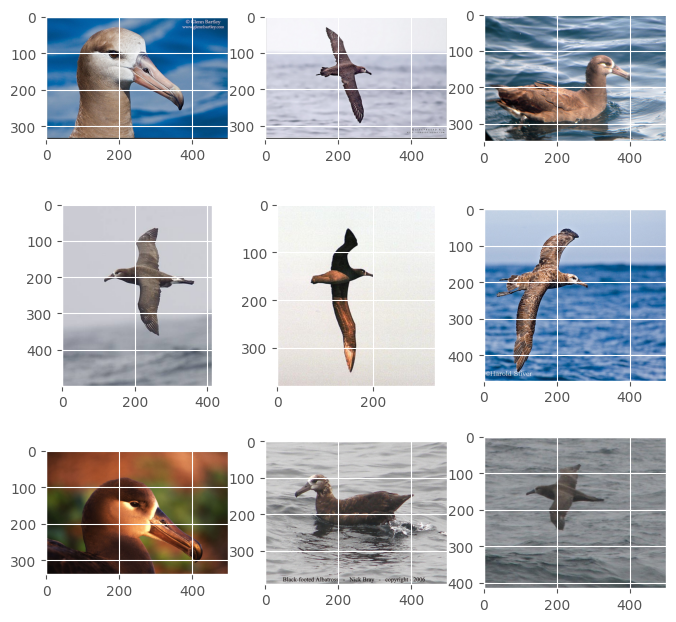

In [ ]:
#Check original image sample
check_images(trainval)

Then we use our first function to make the images the same size:

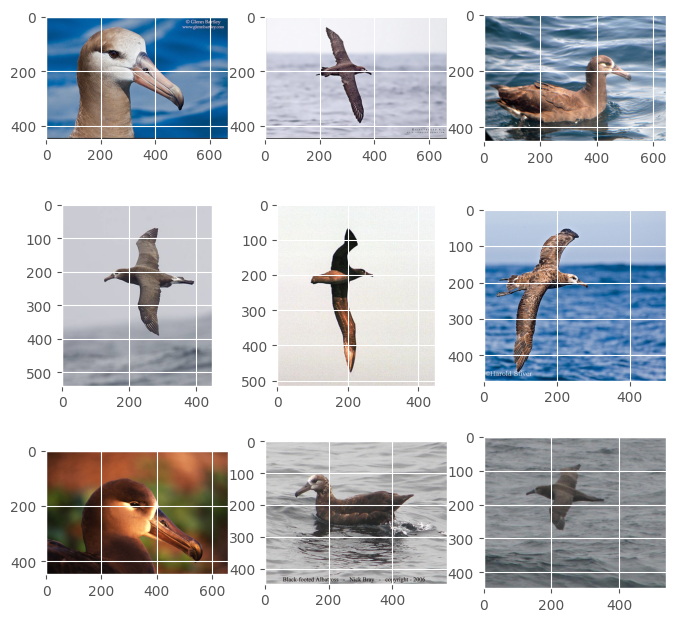

In [ ]:
#Resize images to 448 x 448
trainval_resized = resize_images(trainval, size_target=(448,448), flg_keep_aspect=True)
check_images(trainval_resized)

It can be seen that the scales of the images are now all to 448 x 448 instead of the random pixel values in the first image.

Next,we crop the images around their central points to enhance the focus on the birds. We create duplicates of the resized images to assess the effects of each technique individually rather than observing the combined outcomes.








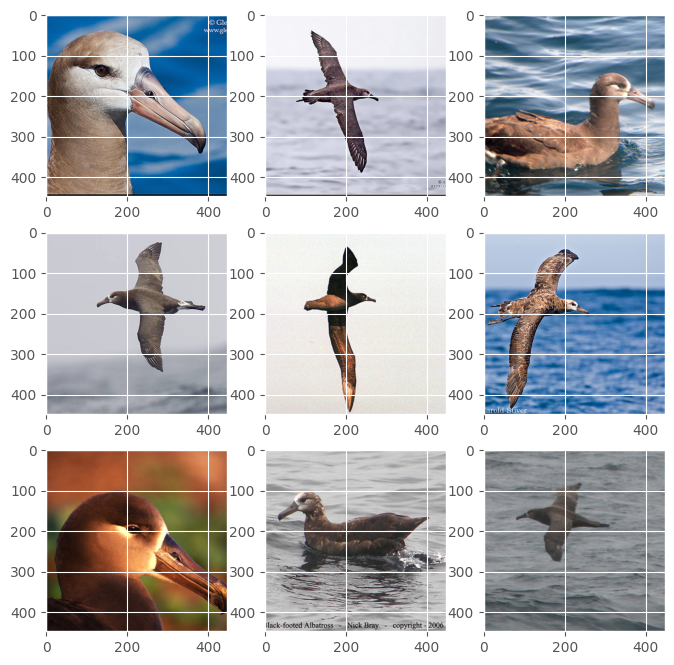

In [ ]:
#Centre-crop images

#Make a copy of the resized images so we don't modify the original ones
trainval_resized_cropped = trainval_resized.copy()

#Use a for loop to crop the resized images
for i in range(9):
    trainval_resized_cropped[i] = center_crop_image(trainval_resized_cropped[i])

check_images(trainval_resized_cropped)

The cropping of the images is evident, maintaining their size at 448 x 448 without losing the resizing. The birds appear clearer compared to the resized images, although some, such as the one in the bottom left, have lost some of their features due to cropping.

A potential enhancement for the future could involve utilizing the bounding boxes provided in the dataset for cropping instead of relying solely on center cropping.

Now we can use some data augmentation techniques on the resized images. First, we randomlu horizontally flip some of the images (~50%):

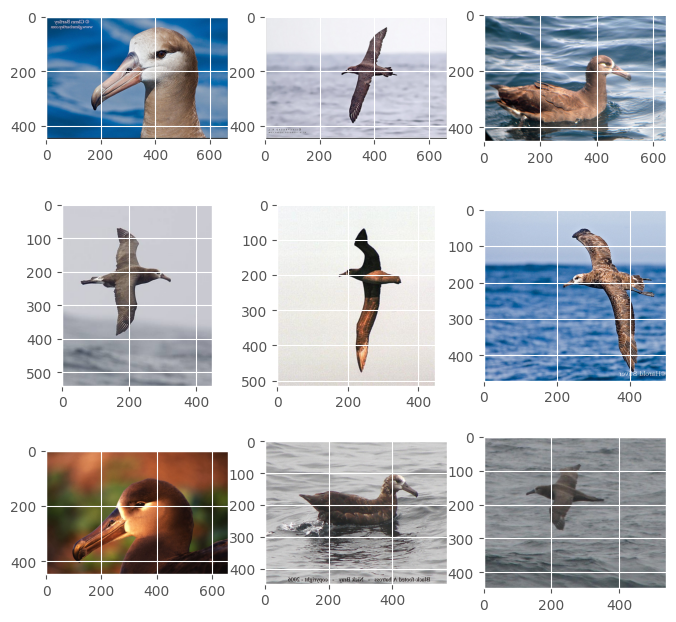

In [ ]:
#Randomly horizontally flip images

#Make a copy of the resize images
trainval_resized_flipped = trainval_resized.copy()

#Use a for loop to randomly flip
for i in range(9):
    trainval_resized_flipped[i] = horizontal_flip_image(trainval_resized_flipped[i])

check_images(trainval_resized_flipped)

4 of the images have now been flipped, which is about half as expected.

Lastly, we can randomly crop some of the images to reflect the random nature of the actual dataset:

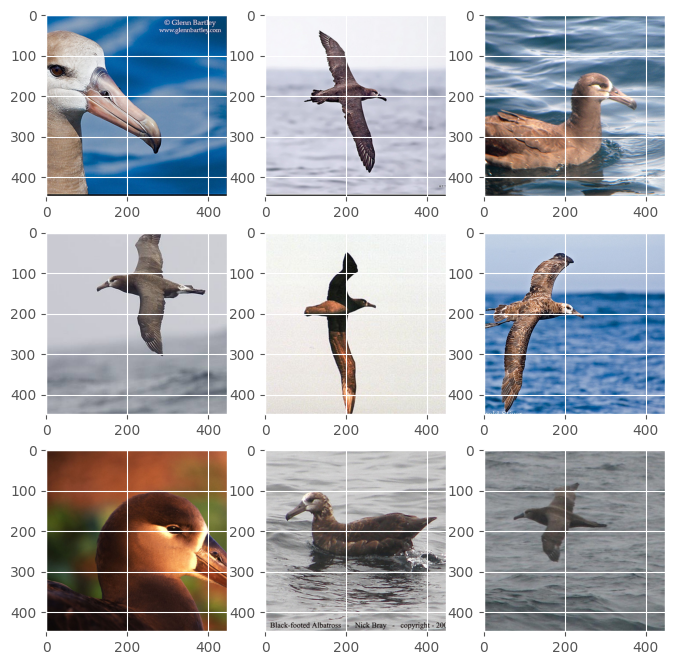

In [ ]:
#Randomly crop images

#Make a copy of the resized images
trainval_resized_cropped = trainval_resized.copy()

#Use a for loop to randomly crop some of the images
for i in range(9):
    trainval_resized_cropped[i] = random_crop_image(trainval_resized_cropped[i])

check_images(trainval_resized_cropped)

Here, we can see some of the images have now been randomly cropped as expected.

##Preprocessing the Training Data

Before we can create our preprocessing pipeline, we will use Keras' preprocessing package to augment batches of the data randomly, adding to the already random nature of the data augmentation techniques. This function will then be used in the pipeline:

In [ ]:
# Import necessary modules from Keras
import keras.backend as backend
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

# Define a custom DirectoryIterator class that inherits from keras.preprocessing.image.DirectoryIterator
class DirectoryIterator(keras.preprocessing.image.DirectoryIterator):
    # Override the _get_batches_of_transformed_samples method
    def _get_batches_of_transformed_samples(self, index_array):

        # Initialize an array to hold the batch of images
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=backend.floatx())
        # Check if the images should be loaded in grayscale
        grayscale = self.color_mode == 'grayscale'

        # Loop over each index in index_array
        for i, j in enumerate(index_array):
            # Get the filename of the current image
            fname = self.filenames[j]
            # Load the image
            img = load_img(os.path.join(self.directory, fname),
                           grayscale=grayscale,
                           target_size=None,
                           interpolation=self.interpolation)
            # Convert the image to an array
            x = img_to_array(img, data_format=self.data_format)
            # Close the image file if necessary
            if hasattr(img, 'close'):
                img.close()
            # Standardize the image
            x = self.image_data_generator.standardize(x)
            # Add the image to the batch
            batch_x[i] = x

        # If save_to_dir is set, save the augmented images to disk
        if self.save_to_dir:
            for i, j in enumerate(index_array):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(
                    prefix=self.save_prefix,
                    index=j,
                    hash=np.random.randint(1e7),
                    format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))

        # Build the batch of labels
        if self.class_mode == 'input':
            batch_y = batch_x.copy()
        elif self.class_mode == 'sparse':
            batch_y = self.classes[index_array]
        elif self.class_mode == 'binary':
            batch_y = self.classes[index_array].astype(backend.floatx())
        elif self.class_mode == 'categorical':
            batch_y = np.zeros((len(batch_x), self.num_classes), dtype=backend.floatx())
            for i, label in enumerate(self.classes[index_array]):
                batch_y[i, label] = 1.
        else:
            return batch_x

        return batch_x, batch_y

# Define a custom ImageDataGenerator class that inherits from keras.preprocessing.image.ImageDataGenerator
class ImageDataGenerator(keras.preprocessing.image.ImageDataGenerator):
    # Override the flow_from_directory method
    def flow_from_directory(self, directory,
                            target_size=(256, 256), color_mode='rgb',
                            classes=None, class_mode='categorical',
                            batch_size=16, shuffle=True, seed=None,
                            save_to_dir=None,
                            save_prefix='',
                            save_format='png',
                            follow_links=False,
                            subset=None,
                            interpolation='nearest'):

        # Return an instance of the custom DirectoryIterator
        return DirectoryIterator(
            directory, self,
            target_size=target_size, color_mode=color_mode,
            classes=classes, class_mode=class_mode,
            data_format=self.data_format,
            batch_size=batch_size, shuffle=shuffle, seed=seed,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format,
            follow_links=follow_links,
            subset=subset,
            interpolation=interpolation)


Now we can define the preprocessing pipeline without having to include the large function definitions above:

In [ ]:
# Define a function to load and preprocess the dataset
def load_data(
    path_data_train=None,
    path_data_valid=None,
    size_width=448,
    size_heigth=448,
    size_mini_batch=16,
    flg_debug=False,
    **kwargs):

    # Define the preprocessing functions for the training and validation data
    # The training data undergoes preprocessing and data augmentation
    func_train = lambda x :normalize_image(random_crop_image(
                                    horizontal_flip_image(
                                        resize_image(x, size_target=(size_heigth,size_width), flg_keep_aspect=True))),
                                        mean=[123.82988033, 127.3509729, 110.25606303])
    # The validation data undergoes only basic preprocessing
    func_valid = lambda x :normalize_image(center_crop_image(
                                    resize_image(x, size_target=(size_heigth,size_width), flg_keep_aspect=True)),
                                    mean=[123.82988033, 127.3509729, 110.25606303])

    # Initialize the ImageDataGenerator with the preprocessing functions
    gen_train = ImageDataGenerator(preprocessing_function=func_train)
    gen_valid = ImageDataGenerator(preprocessing_function=func_valid)

    # Load the training and validation data from the specified directories
    gen_dir_train = gen_train.flow_from_directory(path_data_train,
                                                  target_size=(size_heigth, size_width),
                                                  batch_size=size_mini_batch)
    gen_dir_valid = gen_valid.flow_from_directory(path_data_valid,
                                                  target_size=(size_heigth, size_width),
                                                  batch_size=size_mini_batch,
                                                  shuffle=False)

    # Return the training and validation data generators
    return gen_dir_train, gen_dir_valid


Now we can use to function to create our final datasets for use in the models:

In [ ]:
#Create preprocessed datasets
gen_dir_train, gen_dir_valid = load_data(path_data_train='/content/drive/MyDrive/CUB_200_2011 (1)/CUB_200_2011/images_sorted/train',
                                         path_data_valid='/content/drive/MyDrive/CUB_200_2011 (1)/CUB_200_2011/images_sorted/test',
                                         size_mini_batch=9)

Found 5994 images belonging to 200 classes.
Found 5794 images belonging to 200 classes.


We can see that the train-test split is about equal, with ~6000 images in each dataset.

The last thing we can do is check that the preprocessing pipeline has worked correctly. We can use the .next() function to extract a sample from the training dataset and plot it:

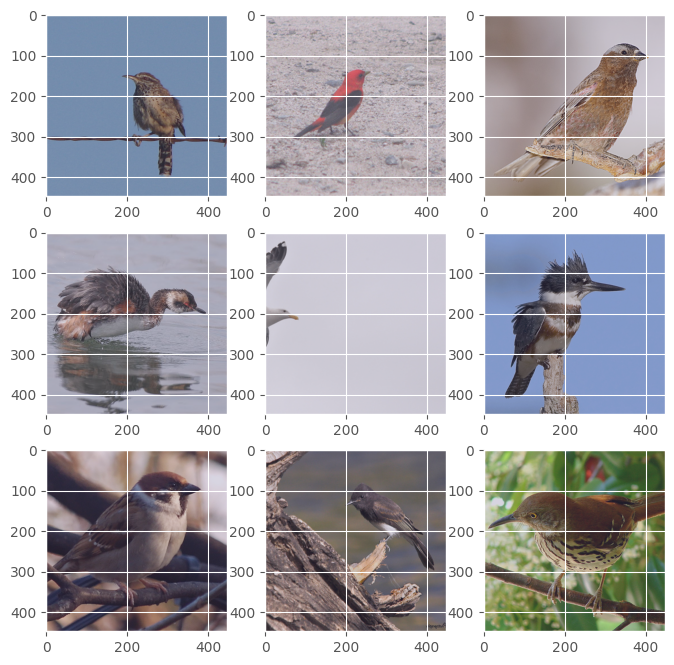

In [ ]:
# check the result of preprocessing.
x_train, y_train = gen_dir_train.next()

# convert from integers to floats
pixels = x_train.astype('float32')

# normalize to the range 0-1
pixels = (pixels - np.min(pixels))/ (np.max(pixels) - np.min(pixels))

#Check images now they are normalised to fit imshow standards
check_images(pixels)

#Implementation and Results

After generating our preprocessed and augmented training data, the next step is to train our models and assess their performance using the validation dataset.

We will employ consistent functions for fine-tuning the models and evaluating their performance, ensuring a fair comparison across all models.

First, we will create a function that fine-tunes the model.  
  
Initially, the model will undergo a basic fine-tuning process, involving 10 epochs of training on the unfrozen layers. Subsequently, a more comprehensive training will take place on all hidden layers for a specified number of epochs, incorporating early stopping.

In [ ]:
# Define a function to fine-tune a pre-trained model
def fine_tuning_model(model, optimizer, batch_size, epochs, frozen_number):

    # Initial training phase with base layers frozen
    for layer in model.layers[:frozen_number]:
        layer.trainable = False

    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    # Fit the model for a few epochs with the base layers frozen
    model.fit(gen_dir_train,
              epochs=10,
              batch_size=batch_size,
              validation_split=0.2)
    print("Initial training with base layers frozen is complete.")

    # Fine-tuning phase with base layers unfrozen
    for layer in model.layers[frozen_number:]:
        layer.trainable = True

    # Set up callbacks for model checkpointing, early stopping, and learning rate reduction on plateau
    checkpoint_cb = keras.callbacks.ModelCheckpoint(model.name + ".h5",
                                                    save_best_only=True,
                                                    monitor="val_loss",
                                                    mode="min",
                                                    verbose=1)

    early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                      restore_best_weights=True,
                                                      monitor="val_loss",
                                                      mode="min",
                                                      verbose=1)

    reduce_lr_plateau_cb = keras.callbacks.ReduceLROnPlateau(patience=5,
                                                             monitor="val_loss",
                                                             mode="min",
                                                             factor=0.1,
                                                             verbose=1)

    # Compile the model again with the base layers unfrozen
    model.compile(optimizer=optimizer,
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    # Fit the model for the specified number of epochs with all layers unfrozen
    history = model.fit(gen_dir_train, batch_size=batch_size, epochs=epochs,
                        validation_split=0.2,
                        callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_plateau_cb])

    print("Fine-tuning with all layers unfrozen is complete.")

    # Return the history object that contains details about the training process
    return history


Next, we'll develop a function to visualize the accuracy and loss of the model on both the training and test data across each epoch.

This enables us to track the model's progress during training and determine when early stopping should be applied.

In [ ]:
#Define the function for evaluating model performance

def history_observation(history):

  #observation of accuracy

  plt.figure(figsize = (12, 6))
  plt.subplot(121)
  plt.plot(history.history["accuracy"])
  plt.plot(history.history["val_accuracy"])

  plt.title("Model Accuracy")
  plt.xlabel("Epoch")
  plt.ylabel("Acccuracy")
  plt.legend(["Train", "Validation"], loc = "upper left")

  plt.show()

  #observation of loss

  plt.figure(figsize = (12, 6))
  plt.subplot(122)
  plt.plot(history.history["loss"])
  plt.plot(history.history["val_loss"])

  plt.title("Model Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(["Train", "Validation"], loc = "upper left")

  plt.show()

##Model 1: VGG16

First, let's discuss the VGG16 model. It's a widely-used convolutional neural network (CNN) architecture known for its simplicity and effectiveness.

First, we need to define the model and input our parameters, then print out the layers of the CNN:

In [ ]:
# define basic VGG16 model

from keras.applications import VGG16

def VGG16_model(img_rows, img_cols):
  a = keras.layers.Input(shape = (img_rows, img_cols, 3))
  a = keras.layers.Lambda(imagenet_utils.preprocess_input)(a)

  base_model = keras.applications.VGG16(input_tensor = a,
                                        include_top = False,
                                        weights = 'imagenet')

  avg = keras.layers.GlobalAveragePooling2D()(base_model.output)

  # dropout -- could be adjusted.
  a = keras.layers.Dense(1024, activation = 'relu',
                         name = 'full_connetect_layer')(avg)

  a = keras.layers.Dropout(rate = 0.2, name = "dropout")(a)

  output = keras.layers.Dense(200, activation = 'softmax', name = 'classification')(a)

  VGG16_model = keras.Model(inputs = base_model.input,
                            outputs = output,
                            name = 'VGG16_Model')

  return VGG16_model


img_rows, img_cols = 448, 448  # could be changed -- 448， 448 / 300, 300 / 64, 64
VGG16_model = VGG16_model(img_rows,img_cols)

VGG16_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "VGG16_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 448, 448, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 448, 448, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 448, 448, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 224, 224, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 224, 224, 128)     73856     
                                                        

Next, we need to know the number of frozen layers so we can input this into the fine-tuning model:

In [ ]:
# check frozen layer number -- 21.

for i,layer in enumerate(VGG16_model.layers):
  print(i,layer.name)

0 input_1
1 lambda
2 block1_conv1
3 block1_conv2
4 block1_pool
5 block2_conv1
6 block2_conv2
7 block2_pool
8 block3_conv1
9 block3_conv2
10 block3_conv3
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_pool
16 block5_conv1
17 block5_conv2
18 block5_conv3
19 block5_pool
20 global_average_pooling2d
21 full_connetect_layer
22 dropout
23 classification


Lastly, we fine-tune the model and evaluate the result:

Epoch 1/5
666/666 [==============================] - 630s 946ms/step - loss: 3.2203 - accuracy: 0.2577 - val_loss: 2.5870 - val_accuracy: 0.3688
Epoch 2/5
666/666 [==============================] - 133s 200ms/step - loss: 2.0354 - accuracy: 0.4747 - val_loss: 2.1734 - val_accuracy: 0.4462
Epoch 3/5
666/666 [==============================] - 133s 199ms/step - loss: 1.4995 - accuracy: 0.6015 - val_loss: 1.9403 - val_accuracy: 0.4919
Epoch 4/5
666/666 [==============================] - 132s 199ms/step - loss: 1.0968 - accuracy: 0.6965 - val_loss: 1.7926 - val_accuracy: 0.5268
Epoch 5/5
666/666 [==============================] - 133s 200ms/step - loss: 0.8516 - accuracy: 0.7672 - val_loss: 1.7189 - val_accuracy: 0.5435
The step of training with base layers fixed has been completed.
Epoch 1/100
666/666 [==============================] - 133s 199ms/step - loss: 0.6993 - accuracy: 0.8104 - val_loss: 1.6506 - val_accuracy: 0.5675

Epoch 00001: val_loss improved from inf to 1.65055, saving mode

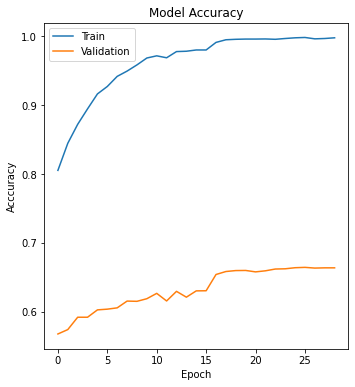

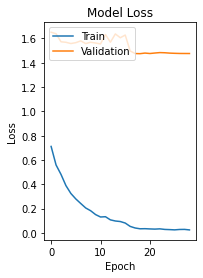

In [ ]:
# put VGG16 model into fine_tuning model for training and evaluate the result

optimizer = optimizers.Adam(lr=0.0001)
batch_size = 64  # could be changed according to the result of preprocessing -- 64 / 32 / 16
epochs = 100
frozen_number = 21

VGG16_history = fine_tuning_model(VGG16_model, optimizer, batch_size, epochs, frozen_number)

##Model 2: Bi-linear CNN

Model 2 is a bilinear CNN based on VGG16. It has 2 streams, both of which use VGG16 models.

First, we need to define the model and input our parameters, then print out the layers of the CNN:

In [ ]:
# Import necessary modules from Keras
from keras.applications import VGG16
from keras import backend as K

# Define helper functions for the Bilinear CNN model
def batch_dot(cnn_ab):
  # This function computes the dot product of two tensors.
  return K.batch_dot(cnn_ab[0], cnn_ab[1], axes = [1, 1])

def sign_sqrt(a):
  # This function applies signed square root to the input tensor.
  return K.sign(a) * K.sqrt(K.abs(a) + 1e-10)

def l2_normalization(a):
  # This function applies L2 normalization to the input tensor.
  return K.l2_normalize(a, axis = -1)

# Define the Bilinear CNN model based on the VGG16 architecture
def Bilinear_VGG16_model(img_rows, img_cols):
  # Create an input tensor and preprocess it
  a = keras.layers.Input(shape = (img_rows, img_cols, 3))
  a = keras.layers.Lambda(imagenet_utils.preprocess_input)(a)

  # Load the VGG16 model without the top layers and with average pooling
  base_model = keras.applications.VGG16(input_tensor = a,
                                        include_top = False,
                                        weights = 'imagenet',
                                        pooling = 'avg')

  # Get the output of the second-to-last layer of the base model
  cnn_a = base_model.layers[-2].output
  cnn_shape = base_model.layers[-2].output_shape
  cnn_a = keras.layers.Reshape([cnn_shape[1] * cnn_shape[2],
                       cnn_shape[-1]])(cnn_a)
  cnn_b = cnn_a
  cnn_dot = keras.layers.Lambda(batch_dot)([cnn_a, cnn_b])
  cnn_dot = keras.layers.Reshape([cnn_shape[-1] * cnn_shape[-1]])(cnn_dot)

  # Apply the sign square root and L2 normalization to the dot product
  sign_sqrt_a = keras.layers.Lambda(sign_sqrt)(cnn_dot)
  l2_normal = keras.layers.Lambda(l2_normalization)(sign_sqrt_a)

  # Add a dense layer with ReLU activation
  a = keras.layers.Dense(1024, activation = 'relu',
                         name = 'full_connetect_layer')(l2_normal)

  # Add a dropout layer for regularization
  a = keras.layers.Dropout(rate = 0.2, name = "dropout")(a)

  # Add the output layer with softmax activation for multi-class classification
  output = keras.layers.Dense(200, activation = 'softmax', name = 'classification')(a)

  # Create the Bilinear CNN model
  Bilinear_VGG16_model = keras.Model(inputs = base_model.input,
                                     outputs = output,
                                     name = 'Bilinear_VGG16_model')

  # Return the model
  return Bilinear_VGG16_model

# Set the dimensions of the input images
img_rows, img_cols = 448, 448  # could be changed -- 448， 448 / 300, 300 / 64, 64

# Create an instance of the Bilinear CNN model
Bilinear_VGG16_model = Bilinear_VGG16_model(img_rows,img_cols)

# Print a summary of the model
Bilinear_VGG16_model.summary()


Model: "Bilinear_VGG16_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 448, 448, 3)]        0         []                            
                                                                                                  
 lambda_1 (Lambda)           (None, 448, 448, 3)          0         ['input_2[0][0]']             
                                                                                                  
 block1_conv1 (Conv2D)       (None, 448, 448, 64)         1792      ['lambda_1[0][0]']            
                                                                                                  
 block1_conv2 (Conv2D)       (None, 448, 448, 64)         36928     ['block1_conv1[0][0]']        
                                                                               

Next, we need to know the number of frozen layers so we can input this into the fine-tuning model:

In [ ]:
# check frozen layer number -- 25.

for i,layer in enumerate(Bilinear_VGG16_model.layers):
  print(i,layer.name)

0 input_2
1 lambda_1
2 block1_conv1
3 block1_conv2
4 block1_pool
5 block2_conv1
6 block2_conv2
7 block2_pool
8 block3_conv1
9 block3_conv2
10 block3_conv3
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_pool
16 block5_conv1
17 block5_conv2
18 block5_conv3
19 block5_pool
20 reshape
21 lambda_2
22 reshape_1
23 lambda_3
24 lambda_4
25 full_connetect_layer
26 dropout
27 classification


Lastly, we fine-tune the model and evaluate the result:

In [ ]:
# put bilinear CNN_1 model into fine_tuning model for training and evaluate the result

optimizer = optimizers.Adam(lr=0.0001)
batch_size = 64  # could be changed according to the result of preprocessing -- 64 / 32 / 16
epochs = 100
frozen_number = 25

Bilinear_VGG16_history = fine_tuning_model(Bilinear_VGG16_model,optimizer,batch_size,epochs,frozen_number)



Epoch 1/5
666/666 [==============================] - 726s 1s/step - loss: 5.2071 - accuracy: 0.0376 - val_loss: 4.6633 - val_accuracy: 0.2123
Epoch 2/5
666/666 [==============================] - 154s 231ms/step - loss: 4.3878 - accuracy: 0.2173 - val_loss: 3.6736 - val_accuracy: 0.3352
Epoch 3/5
666/666 [==============================] - 152s 229ms/step - loss: 3.3961 - accuracy: 0.3669 - val_loss: 2.9260 - val_accuracy: 0.4677
Epoch 4/5
666/666 [==============================] - 154s 232ms/step - loss: 2.6438 - accuracy: 0.4948 - val_loss: 2.4198 - val_accuracy: 0.5495
Epoch 5/5
666/666 [==============================] - 152s 228ms/step - loss: 2.1714 - accuracy: 0.5676 - val_loss: 2.0955 - val_accuracy: 0.5920
The step of training with base layers fixed has been completed.
Epoch 1/100
666/666 [==============================] - 153s 229ms/step - loss: 1.8161 - accuracy: 0.6281 - val_loss: 1.8618 - val_accuracy: 0.6027

Epoch 00001: val_loss improved from inf to 1.86178, saving model t

##Model 3: EfficientNet

EfficientNet is a CNN that carefully scales the network to improve efficiency.

First, we need to define the model and input our parameters, then print out the layers of the CNN:

In [ ]:
# Importing necessary libraries
from tensorflow.keras.applications import EfficientNetB4
from keras import backend as k

# Defining the EfficientNetB4 model
def EfficientNetB4_model(img_rows, img_cols):

  # Clearing the session to avoid clutter from previous models/layers
  k.clear_session()

  # Defining the input layer
  a = keras.layers.Input(shape = (img_rows, img_cols, 3))

  # Loading the EfficientNetB4 model with pre-trained ImageNet weights
  base_model = EfficientNetB4(input_tensor = a, include_top = False, weights = 'imagenet')

  # Adding a global spatial average pooling layer
  avg = keras.layers.GlobalAveragePooling2D()(base_model.output)

  # Adding a fully connected layer
  a = keras.layers.Dense(1024, activation = 'relu')(avg)

  # Adding a dropout layer for regularization
  a = keras.layers.Dropout(rate = 0.5)(a)

  # Adding the final output layer with softmax activation function for multi-class classification
  output = keras.layers.Dense(200, activation = 'softmax', name = 'classification')(a)

  # Creating the model
  EfficientNetB4_model = keras.Model(inputs = base_model.input, outputs = output, name = 'EfficientNetB4_Model')

  # Freezing the layers of the base model for fine-tuning
  base_model.trainable = False

  return EfficientNetB4_model

# Defining the image dimensions
img_rows, img_cols = 448, 448

# Creating the model
EfficientNetB4_model = EfficientNetB4_model(img_rows,img_cols)

# Printing the model summary
EfficientNetB4_model.summary()


71686520/71686520 [==============================] - 1s 0us/step
Model: "EfficientNetB4_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 448, 448, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 448, 448, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 448, 448, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (

Next, we need to know the number of frozen layers so we can input this into the fine-tuning model:

In [ ]:
# check frozen layer number. -- 474

for i,layer in enumerate(EfficientNetB4_model.layers):
  print(i,layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block1b_dwconv
19 block1b_bn
20 block1b_activation
21 block1b_se_squeeze
22 block1b_se_reshape
23 block1b_se_reduce
24 block1b_se_expand
25 block1b_se_excite
26 block1b_project_conv
27 block1b_project_bn
28 block1b_drop
29 block1b_add
30 block2a_expand_conv
31 block2a_expand_bn
32 block2a_expand_activation
33 block2a_dwconv_pad
34 block2a_dwconv
35 block2a_bn
36 block2a_activation
37 block2a_se_squeeze
38 block2a_se_reshape
39 block2a_se_reduce
40 block2a_se_expand
41 block2a_se_excite
42 block2a_project_conv
43 block2a_project_bn
44 block2b_expand_conv
45 block2b_expand_bn
46 block2b_expand_activation
47 block2b_dwconv
48 block2b_bn
49 block2b_activation
50 block2b_se_squeez

Lastly, we fine-tune the model and evaluate the result:

In [ ]:
# put EfficientNetB3 model into fine_tuning model for training and evaluate the result

optimizer = optimizers.RMSprop(lr=2e-5)
batch_size = 64  # could be changed according to the result of preprocessing -- 64 / 32 / 16
epochs = 200
frozen_number = 475
EfficientNetB4_history = fine_tuning_model(EfficientNetB4_model,
                                           optimizer,
                                           batch_size,
                                           epochs,
                                           frozen_number)

# EfficientNetB4_model.compile(loss = "categorical_crossentropy", optimizer = optimizer, metrics = 'accuracy')

# EfficientNetB4_history = EfficientNetB4_model.fit(gen_dir_train, batch_size = batch_size, epochs = epochs, validation_data = gen_dir_valid)

Epoch 1/5
666/666 [==============================] - 3191s 5s/step - loss: 5.2487 - accuracy: 0.0165 - val_loss: 4.8678 - val_accuracy: 0.1814
Epoch 2/5
666/666 [==============================] - 151s 227ms/step - loss: 4.7703 - accuracy: 0.1368 - val_loss: 4.3078 - val_accuracy: 0.3423
Epoch 3/5
666/666 [==============================] - 149s 224ms/step - loss: 4.2239 - accuracy: 0.2413 - val_loss: 3.7008 - val_accuracy: 0.4420
Epoch 4/5
666/666 [==============================] - 150s 225ms/step - loss: 3.6724 - accuracy: 0.3161 - val_loss: 3.1670 - val_accuracy: 0.5076
Epoch 5/5
666/666 [==============================] - 153s 230ms/step - loss: 3.1620 - accuracy: 0.3807 - val_loss: 2.7512 - val_accuracy: 0.5528
The step of training with base layers fixed has been completed.
Epoch 1/200
666/666 [==============================] - 169s 235ms/step - loss: 2.8098 - accuracy: 0.4093 - val_loss: 2.4351 - val_accuracy: 0.5856

Epoch 00001: val_loss improved from inf to 2.43515, saving model 

##Model 3b: EfficientNet with Attention

We implement an improvement on Model 3 by including attention, which enhances important features and fades others to further increase performance.

First, we need to redefine the model and input our parameters, then print out the layers of the CNN:

In [ ]:
pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.0 MB/s eta 0:00:00


In [ ]:
# Importing necessary libraries
from tensorflow.keras.applications import EfficientNetB4
from keras import backend as k

# Defining the EfficientNetB4 model with attention mechanism
def EfficientNetB4_Attention_model(img_rows, img_cols):

  # Clearing the session to avoid clutter from previous models/layers
  k.clear_session()

  # Defining the input layer
  a_input = keras.layers.Input(shape = (img_rows, img_cols, 3))

  # Loading the EfficientNetB4 model with pre-trained ImageNet weights
  base_model = EfficientNetB4(input_shape = (img_rows, img_cols, 3),
                              weights = 'imagenet',
                              include_top = False)

  # Passing the input through the base model
  a = base_model(a_input)

  # Adding a batch normalization layer
  batch_normal = keras.layers.BatchNormalization()(a)

  # Adding a dropout layer for regularization
  a = keras.layers.Dropout(rate = 0.2)(batch_normal)

  # Adding the attention mechanism
  att_layer = keras.layers.Conv2D(64, kernel_size = (1, 1), padding = 'same',
                     activation = 'relu')(a)
  att_layer = keras.layers.Conv2D(16, kernel_size = (1, 1), padding = 'same',
                     activation = 'relu')(att_layer)
  att_layer = keras.layers.Conv2D(8, kernel_size = (1, 1), padding = 'same',
                     activation = 'relu')(att_layer)
  att_layer = keras.layers.Conv2D(1, kernel_size = (1, 1), padding = 'same',
                     activation = 'relu')(att_layer)

  # Applying the attention weights to all the channels
  depth = base_model.get_output_shape_at(0)[-1]
  weight_c = np.ones((1, 1, 1, depth))
  a = keras.layers.Conv2D(depth, kernel_size = (1, 1), padding = 'same',
             activation = 'linear', use_bias = False, weights = [weight_c])
  a.trainable = False
  att_layer = a(att_layer)

  # Multiplying the attention weights with the original activations
  mult = keras.layers.multiply([att_layer, batch_normal])

  # Adding a global average pooling layer
  gap = keras.layers.GlobalAveragePooling2D()(mult)

  # Adding a dropout layer for regularization
  gap_dropout = keras.layers.Dropout(rate = 0.2)(gap)

  # Adding a fully connected layer
  a = keras.layers.Dense(1000, activation = 'relu')(gap_dropout)

  # Adding a dropout layer for regularization
  a = keras.layers.Dropout(rate = 0.2)(a)

  # Adding the final output layer with softmax activation function for multi-class classification
  output = keras.layers.Dense(200, activation = 'softmax', name = 'classification')(a)

  # Creating the model
  EfficientNetB4_Attention_model = keras.Model(inputs = [a_input],
                                               outputs = [output],
                                               name = 'EfficientNetB4_Attention_model')

  return EfficientNetB4_Attention_model

# Defining the image dimensions
img_rows, img_cols = 448, 448

# Creating the model
EfficientNetB4_Attention_model = EfficientNetB4_Attention_model(img_rows,img_cols)


In [ ]:
EfficientNetB4_Attention_model.summary()

Model: "EfficientNetB4_Attention_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 448, 448, 3)]        0         []                            
                                                                                                  
 efficientnetb4 (Functional  (None, 14, 14, 1792)         1767382   ['input_1[0][0]']             
 )                                                        3                                       
                                                                                                  
 batch_normalization (Batch  (None, 14, 14, 1792)         7168      ['efficientnetb4[0][0]']      
 Normalization)                                                                                   
                                                                     

Next, we need to know the number of frozen layers so we can input this into the fine-tuning model:

In [ ]:
# check frozen layer number. -- 12

for i,layer in enumerate(EfficientNetB4_Attention_model.layers):
  print(i,layer.name)

0 input_1
1 efficientnetb4
2 batch_normalization
3 dropout
4 conv2d
5 conv2d_1
6 conv2d_2
7 conv2d_3
8 conv2d_4
9 multiply
10 global_average_pooling2d
11 dropout_1
12 dense
13 dropout_2
14 classification


Lastly, we fine-tune the model and evaluate the result:

In [ ]:
# put into fine_tuning model for training and evaluate the result

optimizer = optimizers.Adam(lr=0.0001)
batch_size = 64  # could be changed according to the result of preprocessing -- 64 / 32 / 16
epochs = 150
frozen_number = 12

EfficientNetB4_Attention_history = fine_tuning_model(EfficientNetB4_Attention_model,
                                           optimizer,
                                           batch_size,
                                           epochs,
                                           frozen_number)



Epoch 1/5
666/666 [==============================] - 817s 1s/step - loss: 4.2191 - accuracy: 0.2362 - val_loss: 3.8869 - val_accuracy: 0.3158
Epoch 2/5
666/666 [==============================] - 150s 225ms/step - loss: 3.5082 - accuracy: 0.3635 - val_loss: 3.4557 - val_accuracy: 0.3656
Epoch 3/5
666/666 [==============================] - 151s 227ms/step - loss: 3.0584 - accuracy: 0.4155 - val_loss: 3.1523 - val_accuracy: 0.3978
Epoch 4/5
666/666 [==============================] - 147s 220ms/step - loss: 2.7684 - accuracy: 0.4548 - val_loss: 2.9274 - val_accuracy: 0.4196
Epoch 5/5
666/666 [==============================] - 146s 219ms/step - loss: 2.5206 - accuracy: 0.4959 - val_loss: 2.7447 - val_accuracy: 0.4406
The step of training with base layers fixed has been completed.
Epoch 1/150
666/666 [==============================] - 164s 229ms/step - loss: 2.3504 - accuracy: 0.5222 - val_loss: 2.6172 - val_accuracy: 0.4515

Epoch 00001: val_loss improved from inf to 2.61716, saving model t

##Model 4: DenseNet121

DenseNet-121 is a dense CNN in which all the layers are interconnected in a feed-forward fashion.

We define the model, train it and print the results of the training epochs:

In [ ]:
import tensorflow as tf
import math
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D, GlobalAveragePooling2D
from tensorflow.keras import Model

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

EPOCHS = 20
BATCH_SIZE =64
NUM_CLASSES = 200
image_height = 224
image_width = 224
channels = 3
save_model_dir = 'saved_model/model'
print(tf.test.gpu_device_name())


pretrained_model = tf.keras.applications.DenseNet121(weights='imagenet',include_top=False,input_shape=(224,224,3))
model = tf.keras.Sequential()
model.add(pretrained_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(512,activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(200,activation='softmax'))
model.summary()


train_dataset, valid_dataset, train_count, valid_count = generate_datasets()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(x=train_dataset,
                    epochs=EPOCHS,
                    validation_data=valid_dataset)

model.save_weights(filepath=save_model_dir, save_format='tf')


/device:GPU:0
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 200)               102600    
Total params: 7,664,904
Trainable params: 7,581,256
Non-trainable params: 83,648
_________________________________________________________________
train: 5994
test: 5794
Epoch 1/20
94/94 [==============================] - 153s 1s/step - l

##Model 5: AlexNet

AlexNet is a deep CNN that has very good accuracy.

First, we need to define the model and input our parameters, then print out the layers of the CNN:

In [ ]:
#CNN AlexNet Model
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.layers.normalization import BatchNormalization

Alex_model=Sequential()
#1 conv layer
Alex_model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",
                 activation="relu",input_shape=(448,448,3)))
#1 max pool layer
Alex_model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
Alex_model.add(BatchNormalization())
#2 conv layer
Alex_model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",
                 activation="relu"))
#2 max pool layer
Alex_model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
Alex_model.add(BatchNormalization())
#3 conv layer
Alex_model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",
                 activation="relu"))
#4 conv layer
Alex_model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",
                 activation="relu"))
#5 conv layer
Alex_model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",
                 activation="relu"))
#3 max pool layer
Alex_model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
Alex_model.add(BatchNormalization())
Alex_model.add(Flatten())
#1 dense layer
Alex_model.add(Dense(4096,input_shape=(448,448,3),activation="relu"))
Alex_model.add(Dropout(0.4))
Alex_model.add(BatchNormalization())
#2 dense layer
Alex_model.add(Dense(4096,activation="relu"))
Alex_model.add(Dropout(0.4))
Alex_model.add(BatchNormalization())
#3 dense layer
Alex_model.add(Dense(1800,activation="relu"))
Alex_model.add(Dropout(0.4))
Alex_model.add(BatchNormalization())
#output layer
Alex_model.add(Dense(200, activation="softmax"))
Alex_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 110, 110, 96)      34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 54, 54, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 54, 54, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 384)       8

In [ ]:
Alex_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Then we train the model to fit the data and print the results:

In [ ]:
Alex_model.fit(x_train, y_train, epochs=100)

Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 6.1953 - accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 4s 4s/step - loss: 5.4403 - accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 4s 4s/step - loss: 3.1078 - accuracy: 0.4444
Epoch 4/100
1/1 [==============================] - 4s 4s/step - loss: 1.4599 - accuracy: 0.7778
Epoch 5/100
1/1 [==============================] - 4s 4s/step - loss: 0.6137 - accuracy: 0.8889
Epoch 6/100
1/1 [==============================] - 4s 4s/step - loss: 0.1706 - accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 4s 4s/step - loss: 0.2370 - accuracy: 1.0000
Epoch 8/100
1/1 [==============================] - 4s 4s/step - loss: 0.0515 - accuracy: 1.0000
Epoch 9/100
1/1 [==============================] - 4s 4s/step - loss: 0.0574 - accuracy: 1.0000
Epoch 10/100
1/1 [==============================] - 4s 4s/step - loss: 0.0031 - accuracy: 1.0000
Epoch 11/100
1/1 [=============

##Model 6: LeNet

LeNet is a simple CNN that AlexNet is based on, and is useful for a baseline comparison between models.

First, we need to define the model and input our parameters, then print out the layers of the CNN:

In [ ]:
##CNN LeNet Model
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

Le_model = Sequential()
Le_model.add(Conv2D(filters=32,kernel_size=(5,5),padding='same',
                 activation='relu',input_shape=(448, 448, 3)))
Le_model.add(MaxPool2D(strides=2))
Le_model.add(Conv2D(filters=48,kernel_size=(5,5),padding='valid',
                 activation='relu'))
Le_model.add(MaxPool2D(strides=2))
Le_model.add(Flatten())
Le_model.add(Dense(256, activation='relu'))
Le_model.add(Dense(256, activation='relu'))
Le_model.add(Dense(200, activation='softmax'))
Le_model.build()
Le_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 448, 448, 32)      2432      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 220, 220, 48)      38448     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 110, 110, 48)      0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 580800)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               148685056 
_________________________________________________________________
dense_12 (Dense)             (None, 256)              

In [ ]:
adam = Adam(lr=5e-4)
Le_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

Then we train the model to fit the data and print the results:

In [ ]:
Le_model.fit(x_train, y_train, epochs=100)

Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 29.0067 - accuracy: 0.1111
Epoch 2/100
1/1 [==============================] - 5s 5s/step - loss: 1878.6504 - accuracy: 0.0000e+00
Epoch 3/100
1/1 [==============================] - 5s 5s/step - loss: 983.5879 - accuracy: 0.3333
Epoch 4/100
1/1 [==============================] - 5s 5s/step - loss: 475.4233 - accuracy: 0.3333
Epoch 5/100
1/1 [==============================] - 5s 5s/step - loss: 126.9645 - accuracy: 0.6667
Epoch 6/100
1/1 [==============================] - 5s 5s/step - loss: 45.5940 - accuracy: 0.8889
Epoch 7/100
1/1 [==============================] - 5s 5s/step - loss: 8.5811 - accuracy: 0.8889
Epoch 8/100
1/1 [==============================] - 5s 5s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 9/100
1/1 [==============================] - 5s 5s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 10/100
1/1 [==============================] - 5s 5s/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 11/100

#Results Analysis

The initial four models utilize a history_observation function to visualize the accuracy and loss metrics for both the training and validation datasets. Additionally, a confusion matrix is generated and saved for each model, which is later displayed in the report.

However, models 5 and 6 were introduced too late in the code development process to include their history and confusion matrices. Instead, we provide their basic accuracy scores below.








##Model 1: VGG16

The model demonstrates exceptionally high accuracy on the training set, reaching approximately 95%, while achieving around 60% accuracy on the validation set. Several factors could contribute to this discrepancy, such as the train-test split or potential issues with generalization.

Although the train-test split recommended by the dataset creators is unlikely to be the cause of lower validation accuracy, it's possible that the model struggles with generalization. However, the validation accuracy is still acceptable.

Furthermore, the loss function exhibits a noticeable difference between the training and validation sets. While the training loss decreases over time as expected, the validation loss remains relatively constant at around 1.6. This discrepancy may indicate overfitting, although further analysis is required to confirm this hypothesis.

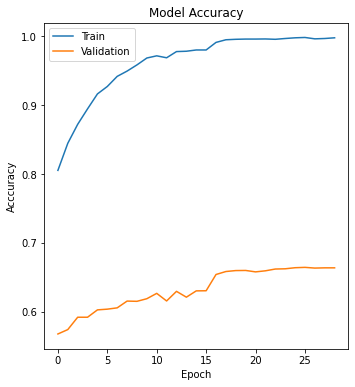

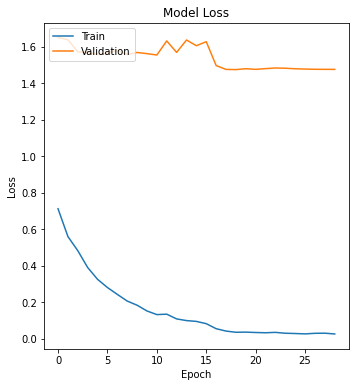

In [ ]:
history_observation(VGG16_history)

In [ ]:
def plot_confusion_matrix(cm,class_num=200,
                          title='Confusion matrix',
                          cmap= plt.get_cmap('Blues') ):
    import itertools
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(200, 160))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(class_num)
    # plt.xticks(tick_marks, classes, rotation=45)
    # plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('./temp/matrix.jpg')
    plt.show()


#
def pred_test_data(models, data_x, data_y):
    from sklearn.metrics import confusion_matrix
    from sklearn import metrics
    prediction = models.predict(data_x)
    # Get most likely class
    predicted_classes = np.argmax(prediction, axis=1)
    true_classes = data_y
    conf_mat = confusion_matrix(y_true=true_classes, y_pred=predicted_classes)
    print(conf_mat)
    report = metrics.classification_report(true_classes, predicted_classes)
    print('test content============================>')
    print(report)

    print('evaluation index============================>')
    accuracy_score = metrics.recall_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('Recall', accuracy_score)
    precision = metrics.precision_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('Precision', precision)
    f1 = metrics.f1_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('F1', f1)
    acc = metrics.accuracy_score(y_true=true_classes, y_pred=predicted_classes, )
    print('acc', acc)
    return conf_mat

## appraise

cm=pred_test_data(VGG16_history.model, gen_dir_valid, gen_dir_valid.classes)
plot_confusion_matrix(cm,200)

This error analysis saves the figures using Pycharm and does not show them; they are included in the Error Analysis section of the report.

##Model 2: Bi-linear CNN

The model exhibits notably high accuracy on the training set, achieving approximately 95%, while the accuracy on the validation set is around 70%. This variance between training and validation accuracies is typical and acceptable, unlike what was observed in Model 1.

Moreover, the loss functions consistently decrease throughout the epochs, indicating that overfitting is not a concern with this model. A loss value of approximately 1 is considered satisfactory for this dataset.

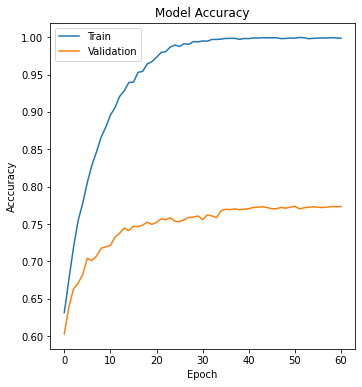

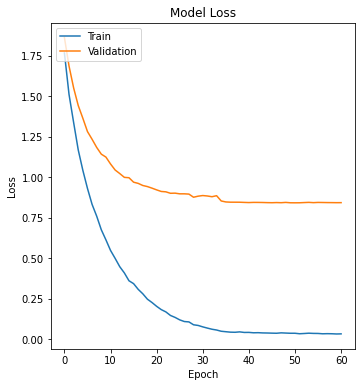

In [ ]:
history_observation(Bilinear_VGG16_history)

In [ ]:
def plot_confusion_matrix(cm,class_num=200,
                          title='Confusion matrix',
                          cmap= plt.get_cmap('Blues') ):
    import itertools
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(200, 160))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(class_num)
    # plt.xticks(tick_marks, classes, rotation=45)
    # plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('./temp/matrix.jpg')
    plt.show()


#
def pred_test_data(models, data_x, data_y):
    from sklearn.metrics import confusion_matrix
    from sklearn import metrics
    prediction = models.predict(data_x)
    # Get most likely class
    predicted_classes = np.argmax(prediction, axis=1)
    true_classes = data_y
    conf_mat = confusion_matrix(y_true=true_classes, y_pred=predicted_classes)
    print(conf_mat)
    report = metrics.classification_report(true_classes, predicted_classes)
    print('test content============================>')
    print(report)

    print('evaluation index============================>')
    accuracy_score = metrics.recall_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('Recall', accuracy_score)
    precision = metrics.precision_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('Precision', precision)
    f1 = metrics.f1_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('F1', f1)
    acc = metrics.accuracy_score(y_true=true_classes, y_pred=predicted_classes, )
    print('acc', acc)
    return conf_mat

## appraise

cm=pred_test_data(Bilinear_history.model, gen_dir_valid, gen_dir_valid.classes)
plot_confusion_matrix(cm,200)

This error analysis saves the figures using Pycharm and does not show them; they are included in the Error Analysis section of the report.

##Model 3: EfficientNet

In comparison to Models 1 and 2, this model exhibits a slightly lower training accuracy. However, its validation accuracy is notably closer to the training accuracy, hovering around 80%. This level of accuracy is quite promising for the dataset.

Moreover, both the loss functions for this model consistently decrease over the epochs, indicating that overfitting is not a significant concern. Although the initial loss value is higher compared to previous models, it converges to a value of approximately 1, which is considered satisfactory for this dataset.

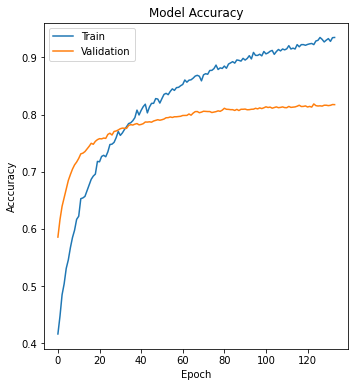

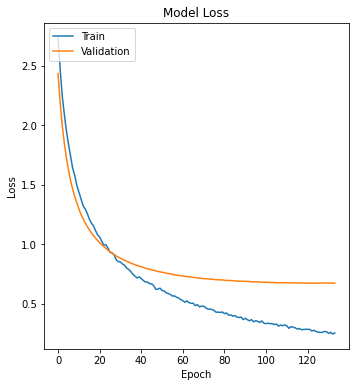

In [ ]:
history_observation(EfficientNetB4_history)

In [ ]:
def plot_confusion_matrix(cm,class_num=200,
                          title='Confusion matrix',
                          cmap= plt.get_cmap('Blues') ):
    import itertools
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(200, 160))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(class_num)
    # plt.xticks(tick_marks, classes, rotation=45)
    # plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('./temp/matrix.jpg')
    plt.show()


#
def pred_test_data(models, data_x, data_y):
    from sklearn.metrics import confusion_matrix
    from sklearn import metrics
    prediction = models.predict(data_x)
    # Get most likely class
    predicted_classes = np.argmax(prediction, axis=1)
    true_classes = data_y
    conf_mat = confusion_matrix(y_true=true_classes, y_pred=predicted_classes)
    print(conf_mat)
    report = metrics.classification_report(true_classes, predicted_classes)
    print('test content============================>')
    print(report)

    print('evaluation index============================>')
    accuracy_score = metrics.recall_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('Recall', accuracy_score)
    precision = metrics.precision_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('Precision', precision)
    f1 = metrics.f1_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('F1', f1)
    acc = metrics.accuracy_score(y_true=true_classes, y_pred=predicted_classes, )
    print('acc', acc)
    return conf_mat

## appraise

cm=pred_test_data(EfficientNetB4_history.model, gen_dir_valid, gen_dir_valid.classes)
plot_confusion_matrix(cm,200)


This error analysis saves the figures using Pycharm and does not show them; they are included in the Error Analysis section of the report.

##Model 3b: EfficientNetB4 with Attention

Attention was incorporated into Model 3 in an effort to enhance its performance, given its highest validation accuracy among the models tested thus far. Surprisingly, although the training accuracy remained unchanged, the validation accuracy decreased after implementing attention, indicating that this modification did not improve the model significantly.

Furthermore, the loss functions for this model consistently decrease over the epochs, indicating that overfitting is not a concern. However, the final validation loss value of approximately 1.5 is higher compared to previous models, further suggesting that the inclusion of attention may not be advantageous for Model 3.

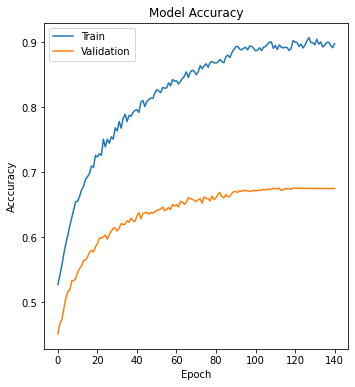

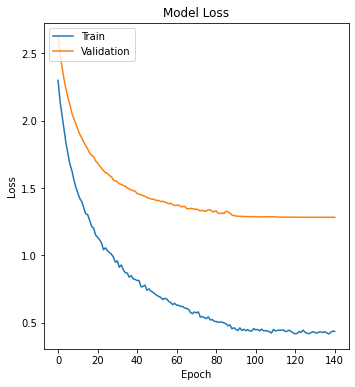

In [ ]:
history_observation(EfficientNetB4_Attention_history)

In [ ]:
def plot_confusion_matrix(cm,class_num=200,
                          title='Confusion matrix',
                          cmap= plt.get_cmap('Blues') ):
    import itertools
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(200, 160))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(class_num)
    # plt.xticks(tick_marks, classes, rotation=45)
    # plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:.2f}'.format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('./temp/matrix.jpg')
    plt.show()

def pred_test_data(models, data_x, data_y):
    from sklearn.metrics import confusion_matrix
    from sklearn import metrics
    prediction = models.predict(data_x)
    # Get most likely class
    predicted_classes = np.argmax(prediction, axis=1)
    true_classes = data_y
    conf_mat = confusion_matrix(y_true=true_classes, y_pred=predicted_classes)
    print(conf_mat)
    report = metrics.classification_report(true_classes, predicted_classes)
    print('test content============================>')
    print(report)

    print('evaluation index============================>')
    accuracy_score = metrics.recall_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('Recall', accuracy_score)
    precision = metrics.precision_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('Precision', precision)
    f1 = metrics.f1_score(y_true=true_classes, y_pred=predicted_classes, average='weighted')
    print('F1', f1)
    acc = metrics.accuracy_score(y_true=true_classes, y_pred=predicted_classes, )
    print('acc', acc)
    return conf_mat

## appraise

cm=pred_test_data(EfficientNetB4_Attention_history.model, gen_dir_valid, gen_dir_valid.classes)
plot_confusion_matrix(cm,200)

This error analysis saves the figures using Pycharm and does not show them; they are included in the Error Analysis section of the report.

##Model 4: DenseNet121

The training accuracy for this model is very good, at almost 100%. The validation accuracy reaches ~70%, which is not the highest model accuracy but still a very good score. This model has potential.  
  
The loss values of the model decrease over time as expected. The final validation loss value of ~1 is a good loss value for this dataset.

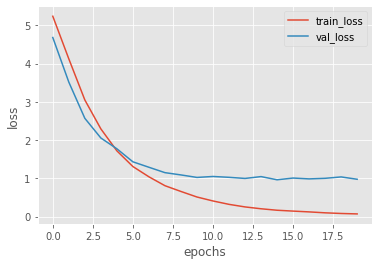

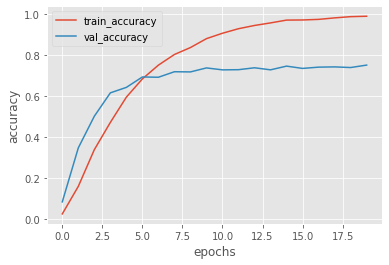

In [ ]:
import matplotlib.pyplot as plt


history_dict = history.history
train_loss = history_dict['loss']
train_accuracy = history_dict['accuracy']
val_loss = history_dict['val_loss']
val_accuracy = history_dict['val_accuracy']

plt.figure()
plt.plot(range(EPOCHS), train_loss, label='train_loss')
plt.plot(range(EPOCHS), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

plt.figure()
plt.plot(range(EPOCHS), train_accuracy, label='train_accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

The confusion matrix presented here is also shown in the report.

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
def plot_confusion_matrix(cm,title='Confusion matrix',cmap=None,normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(200, 160))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2)


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, '{:0.2f}'.format(cm[i, j]),
                     horizontalalignment='center',
                     color='white' if cm[i, j] > thresh else 'black')
        else:
            plt.text(j, i, '{:,}'.format(cm[i, j]),
                     horizontalalignment="center",
                     color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


label_list = []
pred_list = []
cnt = 0
for valid_images, valid_labels in valid_dataset:
    label_list += list(valid_labels)
    predictions = model(valid_images ,training=False )
    pred_class = np.argmax(predictions, axis = 1)
    pred_list += list(pred_class)


confusion_mtx = confusion_matrix(y_true = label_list ,y_pred = pred_list)
plot_confusion_matrix(confusion_mtx, normalize=True)



The number of incorrect predictions and some of the incorrectly predicted labels have been presented here. The model incorrectly labelled 1589 images.

Number of incorrect predictions:  1589
../CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0046_18.jpg


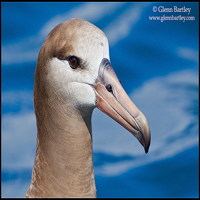

ground truth: 080.Green_Kingfisher
prediction: 082.Ringed_Kingfisher
../CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg


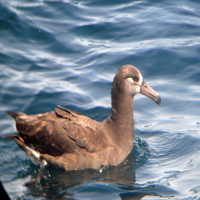

ground truth: 141.Artic_Tern
prediction: 146.Forsters_Tern
../CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0085_92.jpg


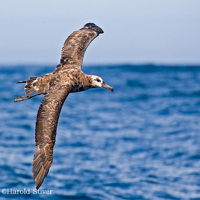

ground truth: 078.Gray_Kingbird
prediction: 135.Bank_Swallow
../CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0025_796057.jpg


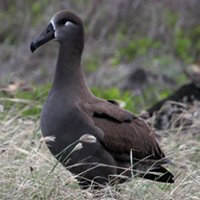

ground truth: 069.Rufous_Hummingbird
prediction: 068.Ruby_throated_Hummingbird
../CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0086_796062.jpg


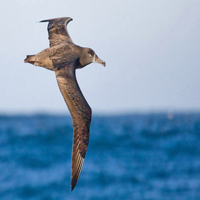

ground truth: 091.Mockingbird
prediction: 049.Boat_tailed_Grackle
../CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0049_796063.jpg


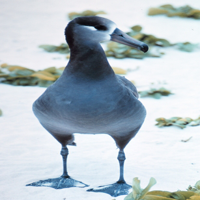

ground truth: 037.Acadian_Flycatcher
prediction: 039.Least_Flycatcher
../CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0006_796065.jpg


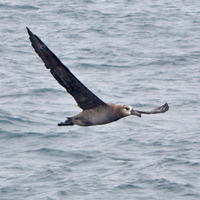

ground truth: 097.Orchard_Oriole
prediction: 161.Blue_winged_Warbler
../CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0016_796067.jpg


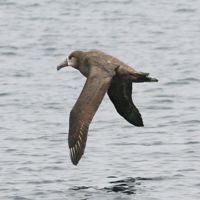

ground truth: 056.Pine_Grosbeak
prediction: 148.Green_tailed_Towhee
../CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0065_796068.jpg


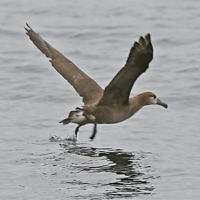

ground truth: 163.Cape_May_Warbler
prediction: 176.Prairie_Warbler
../CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0042_796071.jpg


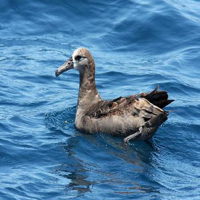

ground truth: 117.Clay_colored_Sparrow
prediction: 128.Seaside_Sparrow


In [ ]:
from PIL import Image
import random
path_list = []
train_val_list = []
class_name_list = []
data_root = '/content/drive/MyDrive/CUB_200_2011 (1)/CUB_200_2011/images'
fp = open('/content/drive/MyDrive/CUB_200_2011 (1)/CUB_200_2011/images.txt')
for line in fp:
    items = line.strip().split()
    path_list.append(os.path.join(data_root,items[1]))
fp.close()


fp = open('/content/drive/MyDrive/CUB_200_2011 (1)/CUB_200_2011/train_test_split.txt')
for line in fp:
    items = line.strip().split()
    train_val_list.append(int(items[1]))
fp.close()


fp = open('/content/drive/MyDrive/CUB_200_2011 (1)/CUB_200_2011/classes.txt')
for line in fp:
    items = line.strip().split()
    class_name_list.append(items[1])
fp.close()

val_img_path_list = [x for i, x in zip(train_val_list, path_list) if i==0]


num_pre = 10
pre_list = [item for item in  zip(img_path_list, pred_list, label_list) if item[1]!=item[2]]
print('Number of incorrect predictions: ',len(pre_list))
pre_list = random.sample(pre_list, num_pre)

for i in range(len(pre_list)):
    img_path, pred, label = pre_list[i]
    if pred != label:
        print(val_img_path_list[i])
        img = Image.open(val_img_path_list[i])
        img = img.resize((200,200))
        display(img)
        print('ground truth:',class_name_list[label])
        print('prediction:',class_name_list[pred])

##Model 5 and 6: AlexNet and LeNet

Unfortunately, Models 5 and 6 were integrated into the code too late to undergo thorough error analysis. However, basic performance scores for these models are provided below.

In the case of AlexNet, although the loss function stands at approximately 1.5, it achieves one of the highest validation accuracies at around 80%.

Conversely, for LeNet, the loss function is notably high, reaching approximately 107, while the accuracy is strikingly low at approximately 22%, indicating the poorest model performance among those evaluated.








In [ ]:
score = Alex_model.evaluate(x_vaild, y_vaild, batch_size=32)
print(score)

1/1 [==============================] - 0s 60ms/step - loss: 1.5367 - accuracy: 0.7778
[1.5367166996002197, 0.7777777910232544]


In [ ]:
score = Le_model.evaluate(x_vaild, y_vaild, batch_size=32)
print(score)

1/1 [==============================] - 1s 1s/step - loss: 107.1734 - accuracy: 0.2222
[107.17339324951172, 0.2222222238779068]
